# Pretrained critic

#### Imports

In [1]:
from abc import ABC, abstractmethod
from itertools import pairwise

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from kilroyplot.plot import plt
from torch.distributions.categorical import Categorical
import einops as ein

#### Configuration

In [2]:
start_word, stop_word, pad_word = 1, 2, 0
vocab_size = max(4, 10)
max_length = 5
embedding_dim, hidden_dim, out_dim = 16, 16, vocab_size

n_times = 10

n_samples = 2000

critic_epochs = 500
critic_batch_size = 100
critic_lr = 0.1

policy_epochs = 2000
policy_sample_size = 20
policy_lr = 0.3

#### Seeding

In [3]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

#### Utilities

In [4]:
def squash_packed(x, fn):
    return rnn.PackedSequence(
        fn(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices
    )


def unpad_sequence(x, lengths):
    return [s[:length] for s, length in zip(x, lengths)]

#### Reward function

In [5]:
class RewardFunction(ABC):
    @abstractmethod
    def __call__(self, x):
        pass

In [6]:
class ZigzagRewardFunction(RewardFunction):
    def __init__(self, vocab_size, max_length):
        self._vocab_size = vocab_size
        self._max_length = max_length

    def _score(self, x):
        maximum = (self._vocab_size - 1) * (self._max_length - 1)
        return sum([np.abs(b - a) for a, b in pairwise(x)]) / maximum

    def __call__(self, x):
        sequences = rnn.unpack_sequence(x)
        scores = [torch.tensor([[self._score(s)]] * len(s)) for s in sequences]
        return rnn.pack_sequence(scores, enforce_sorted=False)

In [7]:
reward_function = ZigzagRewardFunction(vocab_size, max_length)

#### Data

In [8]:
class DummyGenerator:
    def __init__(self, start_word, end_word, pad_word, max_length):
        self.start_word = start_word
        self.end_word = end_word
        self.pad_word = pad_word
        self.max_length = max_length

    def generate(self, n=1):
        out = []
        x = torch.tensor([[self.start_word]] * n)
        i = 1
        while len(x) > 0 and i < self.max_length:
            next_words = self._sample(len(x))
            x = torch.cat((x, next_words.unsqueeze(-1)), dim=-1)
            finished_mask = next_words == self.end_word
            finished = x[finished_mask]
            out.extend(list(finished))
            x = x[~finished_mask]
            i += 1
        out.extend(list(x))
        out = sorted(out, key=lambda s: len(s), reverse=True)
        lengths = [len(s) for s in out]
        out = rnn.pad_sequence(
            out, batch_first=True, padding_value=self.pad_word
        )
        return rnn.pack_padded_sequence(out, lengths, batch_first=True)

    def _sample(self, n):
        return torch.randint(vocab_size, (n,))

In [9]:
samples = DummyGenerator(start_word, stop_word, pad_word, max_length).generate(
    n_samples
)

In [10]:
rewards = reward_function(samples)

#### Critic

In [11]:
class Critic(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = (
            squash_packed(x, self.embedding)
            if is_packed
            else self.embedding(x)
        )
        ht, _ = self.lstm(x)
        return squash_packed(ht, self.linear) if is_packed else self.linear(ht)

In [12]:
class CriticRewardFunction(RewardFunction):
    def __init__(self, critic):
        self._critic = critic

    def __call__(self, x):
        rewards = self._critic(x)
        return rnn.pack_sequence(
            [r - r[0] for r in rnn.unpack_sequence(rewards)]
        )

#### Critic training

In [13]:
def train_epoch(
    critic,
    samples,
    rewards,
    optimizer,
    pad_word,
    batch_size,
):
    losses = []
    samples = rnn.unpack_sequence(samples)
    rewards = rnn.unpack_sequence(rewards)
    for i in range(0, len(samples), batch_size):
        optimizer.zero_grad()

        batch_samples = samples[i : i + batch_size]
        batch_samples_padded = rnn.pad_sequence(
            batch_samples, batch_first=True, padding_value=pad_word
        )
        batch_samples_packed = rnn.pack_padded_sequence(
            batch_samples_padded,
            [len(s) for s in batch_samples_padded],
            batch_first=True,
        )

        batch_rewards = rewards[i : i + batch_size]
        batch_rewards_padded = rnn.pad_sequence(
            batch_rewards, batch_first=True, padding_value=0.0
        )
        batch_rewards_packed = rnn.pack_padded_sequence(
            batch_rewards_padded,
            [len(s) for s in batch_rewards_padded],
            batch_first=True,
        )

        predicted_rewards = critic(batch_samples_packed)

        loss = F.mse_loss(predicted_rewards.data, batch_rewards_packed.data)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return torch.tensor(losses)

In [14]:
def train(
    critic,
    samples,
    rewards,
    optimizer,
    pad_word,
    batch_size,
    epochs,
):
    losses = []
    for i in range(epochs):
        epoch_losses = train_epoch(
            critic,
            samples,
            rewards,
            optimizer,
            pad_word,
            batch_size,
        )
        losses.append(epoch_losses.mean().item())
    return torch.tensor(losses)

In [15]:
critic = Critic(vocab_size, embedding_dim, hidden_dim)
optimizer = optim.SGD(critic.parameters(), lr=critic_lr)
losses = train(
    critic,
    samples,
    rewards,
    optimizer,
    pad_word,
    critic_batch_size,
    critic_epochs,
)

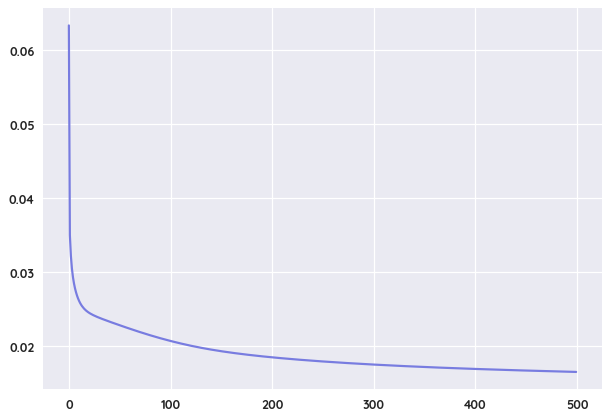

In [16]:
plt.plot(losses)

#### Policy

In [17]:
class Policy(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = (
            squash_packed(x, self.embedding)
            if is_packed
            else self.embedding(x)
        )
        out, _ = self.lstm(x)
        y = squash_packed(out, self.linear) if is_packed else self.linear(out)
        return (
            squash_packed(y, lambda yf: F.log_softmax(yf, dim=-1))
            if is_packed
            else F.log_softmax(y, dim=-1)
        )

In [18]:
class Generator:
    def __init__(self, model, start_word, end_word, pad_word, max_length):
        self.model = model
        self.start_word = start_word
        self.end_word = end_word
        self.pad_word = pad_word
        self.max_length = max_length

    def generate(self, n=1):
        out = []
        x = torch.tensor([[self.start_word]] * n)
        i = 1
        while len(x) > 0 and i < self.max_length:
            batched_logprobs = self.model(x)[:, -1]
            next_words = self.pick_words(batched_logprobs)
            x = torch.cat((x, next_words.unsqueeze(-1)), dim=-1)
            finished_mask = next_words == self.end_word
            finished = x[finished_mask]
            out.extend(list(finished))
            x = x[~finished_mask]
            i += 1
        out.extend(list(x))
        out = sorted(out, key=lambda s: len(s), reverse=True)
        lengths = [len(s) for s in out]
        out = rnn.pad_sequence(
            out, batch_first=True, padding_value=self.pad_word
        )
        return rnn.pack_padded_sequence(out, lengths, batch_first=True)

    def pick_words(self, batched_logprobs):
        return torch.tensor(
            [
                Categorical(logprobs.exp()).sample()
                for logprobs in batched_logprobs
            ]
        )

#### Loss function

In [19]:
class LossFunction:
    def __call__(self, logprobs, sentences, rewards):
        logprobs = rnn.unpack_sequence(logprobs)
        sentences = rnn.unpack_sequence(sentences)
        rewards = rnn.unpack_sequence(rewards)
        logprobs = [
            torch.gather(p[:-1], -1, s[1:].unsqueeze(-1)).squeeze(-1)
            for s, p in zip(sentences, logprobs)
        ]
        loss = torch.stack(
            [-(r[1:].flatten() * p).mean() for p, r in zip(logprobs, rewards)]
        )
        return loss.mean()

In [20]:
loss_function = LossFunction()

#### Policy training

In [21]:
def train_iteration(
    policy,
    generator,
    sample_size,
    optimizer,
    training_reward_function,
    evaluation_reward_function,
    loss_function,
    pad_word,
):
    optimizer.zero_grad()
    sentences = generator.generate(sample_size)
    training_rewards = training_reward_function(sentences)
    evaluation_rewards = evaluation_reward_function(sentences)
    logprobs = policy(sentences)
    loss = loss_function(logprobs, sentences, training_rewards)
    loss.backward()
    optimizer.step()
    return (
        loss.item(),
        torch.stack(
            [r.mean() for r in rnn.unpack_sequence(evaluation_rewards)]
        )
        .mean()
        .item(),
    )

In [22]:
def train(
    policy,
    generator,
    epochs,
    sample_size,
    optimizer,
    training_reward_function,
    evaluation_reward_function,
    loss_function,
    pad_word,
):
    losses, rewards = [], []
    for i in range(epochs):
        loss, reward = train_iteration(
            policy,
            generator,
            sample_size,
            optimizer,
            training_reward_function,
            evaluation_reward_function,
            loss_function,
            pad_word,
        )
        losses.append(loss)
        rewards.append(reward)
    return torch.tensor(losses), torch.tensor(rewards)

In [23]:
def run(
    n_times,
    vocab_size,
    embedding_dim,
    hidden_dim,
    out_dim,
    start_word,
    stop_word,
    pad_word,
    max_length,
    epochs,
    sample_size,
    lr,
    training_reward_function,
    evaluation_reward_function,
    loss_function,
):
    rewards = []
    for i in range(n_times):
        policy = Policy(vocab_size, embedding_dim, hidden_dim, out_dim)
        generator = Generator(
            policy, start_word, stop_word, pad_word, max_length
        )
        optimizer = optim.SGD(policy.parameters(), lr=lr)
        _, r = train(
            policy,
            generator,
            epochs,
            sample_size,
            optimizer,
            training_reward_function,
            evaluation_reward_function,
            loss_function,
            pad_word,
        )
        rewards.append(r)
    return torch.stack(rewards)

In [24]:
rewards_base = run(
    n_times=n_times,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    start_word=start_word,
    stop_word=stop_word,
    pad_word=pad_word,
    max_length=max_length,
    epochs=policy_epochs,
    sample_size=policy_sample_size,
    lr=policy_lr,
    training_reward_function=reward_function,
    evaluation_reward_function=reward_function,
    loss_function=loss_function,
)

In [25]:
rewards_critic = run(
    n_times=n_times,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    start_word=start_word,
    stop_word=stop_word,
    pad_word=pad_word,
    max_length=max_length,
    epochs=policy_epochs,
    sample_size=policy_sample_size,
    lr=policy_lr,
    training_reward_function=CriticRewardFunction(critic),
    evaluation_reward_function=reward_function,
    loss_function=loss_function,
)

#### Results

In [26]:
def plot_rewards(
    rewards, label, x_label="Iteration", y_label="Reward", alpha=0.5
):
    rewards = ein.rearrange(rewards, "n t -> t n")
    median = rewards.median(dim=1).values
    lower, upper = np.percentile(rewards, [25, 75], axis=1)
    plt.plot(median, label=label)
    plt.fill_between(range(len(median)), lower, upper, alpha=alpha)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

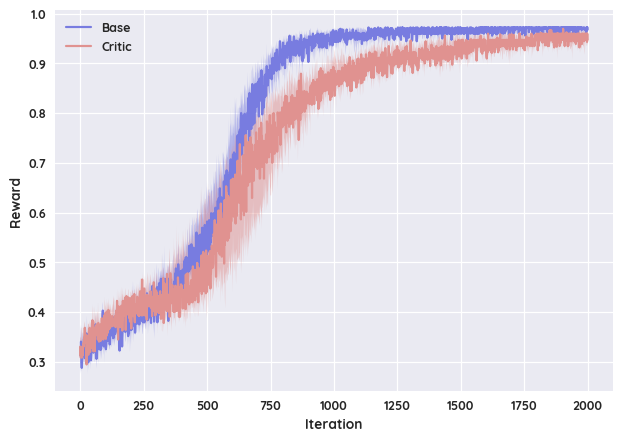

In [27]:
plot_rewards(rewards_base, "Base")
plot_rewards(rewards_critic, "Critic")